# Loading and Preparing List of URLs

In [1]:
## Getting the list of URLS from the official CSV 
## https://gitlab.com/recommend.games/bgg-ranking-historicals/-/tree/master?ref_type=heads

import pandas as pd

df = pd.read_csv('FullBGGData_2024-07-29.csv', sep=',', header=0)
df.head()

,ID,Name,Year,Rank,Average,Bayes average,Users rated,URL,Thumbnail
0,224517,Brass: Birmingham,2018,1,8.60,8.415,46492,/boardgame/224517/brass-birmingham,https://cf.geekdo-images.com/x3zxjr-Vw5iU4yDPg...
1,161936,Pandemic Legacy: Season 1,2015,2,8.53,8.378,53697,/boardgame/161936/pandemic-legacy-season-1,https://cf.geekdo-images.com/-Qer2BBPG7qGGDu6K...
2,174430,Gloomhaven,2017,3,8.59,8.351,62439,/boardgame/174430/gloomhaven,https://cf.geekdo-images.com/sZYp_3BTDGjh2unaZ...
3,342942,Ark Nova,2021,4,8.53,8.334,44277,/boardgame/342942/ark-nova,https://cf.geekdo-images.com/SoU8p28Sk1s8MSvoM...
4,233078,Twilight Imperium: Fourth Edition,2017,5,8.60,8.240,24022,/boardgame/233078/twilight-imperium-fourth-edi...,https://cf.geekdo-images.com/_Ppn5lssO5OaildSE...


In [2]:
baseurl = 'https://boardgamegeek.com'
listurls = df.URL.to_list()
listurls = [baseurl + url for url in listurls]
print(f'Number of URLs: {len(listurls)}')
print()
listurls[:3]

Number of URLs: 26717



['https://boardgamegeek.com/boardgame/224517/brass-birmingham',
 'https://boardgamegeek.com/boardgame/161936/pandemic-legacy-season-1',
 'https://boardgamegeek.com/boardgame/174430/gloomhaven']

# Functions

In [32]:
import requests
import json
from bs4 import BeautifulSoup
import time
import pandas as pd  # Import the pandas library
import re

def fetch_page_content(url, headers={'User-Agent': 'Mozilla/5.0'}):
    try:
        response = requests.get(url, headers=headers)
        response.raise_for_status()
        return response.content
    except requests.RequestException as e:
        print(f"Error fetching URL {url}: {e}")
        return None

def parse_html(html_content):
    return BeautifulSoup(html_content, "html.parser")

def extract_game_data(soup, url, rank):
    game_data = {}
    objectid = url.split('/')[-2]

    title_tag = soup.find('title')
    title_text = title_tag.text.split('|')[0] if title_tag else 'Unknown'
    game_data['Title'] = title_text

    json_data_match = re.search(r'GEEK\.geekitemPreload = ({.*?});', str(soup))
    if json_data_match:
        try:
            json_data = json.loads(json_data_match.group(1))
            game_data['Link'] = url
            game_data['Rank'] = rank  # Store in dictionary 
            year_published = json_data.get('item', {}).get('yearpublished', 'Unknown')
            game_data['Year'] = year_published  # Store in dictionary        
            # Extract additional game info
            stats = json_data.get('item', {}).get('stats', {})
            game_data['UsersRated'] = stats.get('usersrated', 'Unknown')
            game_data['AveRating'] = stats.get('average', 'Unknown')
            game_data['Baverage'] = stats.get('baverage', 'Unknown')
            game_data['StdDev'] = stats.get('stddev', 'Unknown')
            game_data['AveWeight'] = stats.get('avgweight', 'Unknown')
            game_data['NumWeights'] = stats.get('numweights', 'Unknown')
            game_data['NumPlays'] = stats.get('numplays', 'Unknown')
            linkcounts = json_data.get('item', {}).get('linkcounts', {})
            game_data['NumAwards'] = linkcounts.get('boardgamehonor', 0)
            ###########################
            polls = json_data.get('item', {}).get('polls', {})
            # if polls is empty then 'NA'
            if polls == {}:
                game_data['PCountRecomm_min'] = 'NA'
                game_data['PCountRecomm_max'] = 'NA'
                game_data['PCountBest_min'] = 'NA'
                game_data['PCountBest_max'] = 'NA'
                game_data['PCount_votes'] = 'NA'
            else:
                # if empty list then 'NA'
                if polls['userplayers']['recommended'] == []:
                    game_data['PCountRecomm_min'] = 'NA'
                    game_data['PCountRecomm_max'] = 'NA'
                else:
                    game_data['PCountRecomm_min'] = polls.get('userplayers', 'Unknown')['recommended'][0]['min']
                    game_data['PCountRecomm_max'] = polls.get('userplayers', 'Unknown')['recommended'][0]['max']
                if polls['userplayers']['best'] == []:
                    game_data['PCountBest_min'] = 'NA'
                    game_data['PCountBest_max'] = 'NA'
                else:
                    game_data['PCountBest_min'] = polls.get('userplayers', 'Unknown')['best'][0]['min']
                    game_data['PCountBest_max'] = polls.get('userplayers', 'Unknown')['best'][0]['max']
                game_data['PCount_votes'] = polls.get('userplayers', 'Unknown')['totalvotes']
            ########################
            game_data['MinPlayTime'] = json_data.get('item', {}).get('minplaytime', 'NA')
            game_data['MaxPlayTime'] = json_data.get('item', {}).get('maxplaytime', 'NA')
            mechanics = json_data.get('item', {}).get('links', {}).get('boardgamemechanic', [])
            mechstring = ''
            for i, mech in enumerate(mechanics):
                mechstring += mech['name']
                if i < len(mech)-1:
                    mechstring += '\n'
            game_data['Mechanics'] = mechstring          
            rankinfo = json_data.get('item', {}).get('rankinfo', [])
            for i, rinf in enumerate(rankinfo):
                if rinf['prettyname'] != 'Board Game Rank':
                    game_data['GameCategory_'+str(i)] = rinf['veryshortprettyname']
                    game_data['RankCategory_'+str(i)] = rinf['rank']
                    game_data['ScoreCategory_'+str(i)] = rinf['baverage']          
            rank += 1
        except json.JSONDecodeError as e:
            print(f"JSONDecodeError: {e}")
    else:
        print("JSON data not found in HTML content.")

    # Amazon price extraction logic
    amazon_url = "https://api.geekdo.com/api/amazon/textads"
    params = {"locale": "us", "objectid": objectid, "objecttype": "thing"}
    response = requests.get(amazon_url, params=params)
    if response.status_code == 200:
        amazon_data = response.json()
        if isinstance(amazon_data, dict):  # Check if the response is a dictionary
            price = amazon_data.get('us', {}).get('newprice', 'Unknown')
        else:
            price = 'Unknown'
        game_data['AmazonPrice'] = price
    else:
        game_data['AmazonPrice'] = 'Unknown'

    return game_data

def scrape_boardgame_data(url, games_data_df=pd.DataFrame(), headers={'User-Agent': 'Mozilla/5.0'}, rank=1):
    # if url is already in the dataframe, skip
    if url in games_data_df.Link.values:
        print(f"URL {url} already in dataframe. Skipping.")
        return games_data_df
    else:
        print(f"Fetching URL {url}") 
        html_content = fetch_page_content(url, headers)
        if html_content:
            soup = parse_html(html_content)
            game_data = extract_game_data(soup, url, rank)
            if game_data:
                series = pd.DataFrame([game_data])
                games_data_df = pd.concat([games_data_df, series], ignore_index=True)
            return games_data_df
        else:
            print(f"Error fetching URL {url}")
            return games_data_df

# Actually scrapping the data

In [33]:
num_urls_subset = 5000

rank = 1
games_data_df = pd.DataFrame()
for url in listurls[:num_urls_subset]:
    games_data_df = scrape_boardgame_data(url, games_data_df, rank=rank)
    rank += 1

games_data_df.head()

URL https://boardgamegeek.com/boardgame/224517/brass-birmingham already in dataframe. Skipping.
URL https://boardgamegeek.com/boardgame/161936/pandemic-legacy-season-1 already in dataframe. Skipping.
URL https://boardgamegeek.com/boardgame/174430/gloomhaven already in dataframe. Skipping.
URL https://boardgamegeek.com/boardgame/342942/ark-nova already in dataframe. Skipping.
URL https://boardgamegeek.com/boardgame/233078/twilight-imperium-fourth-edition already in dataframe. Skipping.
URL https://boardgamegeek.com/boardgame/316554/dune-imperium already in dataframe. Skipping.
URL https://boardgamegeek.com/boardgame/167791/terraforming-mars already in dataframe. Skipping.
URL https://boardgamegeek.com/boardgame/115746/war-of-the-ring-second-edition already in dataframe. Skipping.
URL https://boardgamegeek.com/boardgame/187645/star-wars-rebellion already in dataframe. Skipping.
URL https://boardgamegeek.com/boardgame/291457/gloomhaven-jaws-of-the-lion already in dataframe. Skipping.
URL 

,Title,Link,Rank,Year,UsersRated,AveRating,Baverage,StdDev,AveWeight,NumWeights,...,GameCategory_1,RankCategory_1,ScoreCategory_1,AmazonPrice,GameCategory_2,RankCategory_2,ScoreCategory_2,GameCategory_3,RankCategory_3,ScoreCategory_3
0,Brass: Birmingham,https://boardgamegeek.com/boardgame/224517/bra...,1,2018,46540,8.5961,8.41468,1.4164,3.8772,2247,...,Strategy,1,8.43077,$65.47,NaN,NaN,NaN,NaN,NaN,NaN
1,Pandemic Legacy: Season 1,https://boardgamegeek.com/boardgame/161936/pan...,2,2015,53711,8.5261,8.37788,1.59831,2.8306,1464,...,Thematic,1,8.378,$64.98,Strategy,2,8.36589,NaN,NaN,NaN
2,Gloomhaven,https://boardgamegeek.com/boardgame/174430/glo...,3,2017,62465,8.58674,8.35067,1.73879,3.9123,2576,...,Thematic,2,8.32928,$196.32,Strategy,4,8.3123,NaN,NaN,NaN
3,Ark Nova,https://boardgamegeek.com/boardgame/342942/ark...,4,2021,44343,8.5343,8.33386,1.3851,3.7647,2337,...,Strategy,3,8.34315,$55.00,NaN,NaN,NaN,NaN,NaN,NaN
4,Twilight Imperium: Fourth Edition,https://boardgamegeek.com/boardgame/233078/twi...,5,2017,24043,8.59935,8.24016,1.62171,4.3175,1178,...,Thematic,3,8.26118,$131.99,Strategy,5,8.26135,NaN,NaN,NaN


## ... Continuation?

In [26]:
lasturl = games_data_df['Link'].iloc[-1]

initialize = False
for url in listurls[:num_urls_subset]:
    if url == lasturl:
        initialize = True
        continue    
    if initialize:
        games_data_df = scrape_boardgame_data(url, games_data_df, rank=rank)
        rank += 1

## I had some duplicates in the data. Delete those

In [39]:
# remove duplicated rows, games_data_df[ games_data_df.duplicated() ]
games_data_df = games_data_df.drop_duplicates(subset=['Link'])

## Save data to PICKLE file

In [41]:
games_data_df.to_pickle('games_data_df.pkl')

## Load data to PICKLE file

In [54]:
games_data_df = pd.read_pickle('games_data_df.pkl')

Sometimes the scrapping crashes due to connection problems.

#  Data Preprocessing

In [55]:
columnstonum = ['Rank', 'Year', 'UsersRated', 'NumWeights', 'NumPlays', 'NumAwards', 'PCountRecomm_min', 
                'PCountRecomm_max', 'PCountBest_min', 'PCountBest_max', 'PCount_votes', 'MinPlayTime', 'MaxPlayTime',
                'RankCategory_1', 'RankCategory_2',
                'AveRating', 'Baverage', 'StdDev', 'AveWeight', 'ScoreCategory_1', 'ScoreCategory_2']
for col in columnstonum:
    games_data_df[col] = pd.to_numeric(games_data_df[col], errors='coerce')

# remove $ from AmazonPrice and convert to numeric
games_data_df['AmazonPrice'] = games_data_df['AmazonPrice'].str.replace('$', '')
games_data_df['AmazonPrice'] = pd.to_numeric(games_data_df['AmazonPrice'], errors='coerce')

games_data_df.describe()

,Rank,Year,UsersRated,AveRating,Baverage,StdDev,AveWeight,NumWeights,NumPlays,NumAwards,...,PCountBest_min,PCountBest_max,PCount_votes,MinPlayTime,MaxPlayTime,RankCategory_1,ScoreCategory_1,AmazonPrice,RankCategory_2,ScoreCategory_2
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,...,4995.000000,4972.000000,5000.000000,5000.000000,5000.000000,4634.000000,4634.000000,2291.000000,906.000000,906.000000
mean,2500.500000,2007.667000,4174.735000,7.166642,6.246054,1.373532,2.378331,198.43620,16740.216000,2.151800,...,3.145746,3.385157,77.436600,60.067400,104.504800,620.975399,6.505896,55.140602,736.325607,6.423836
std,1443.520003,100.163805,8737.162959,0.528140,0.481803,0.180307,0.806106,440.39864,47876.716615,4.246594,...,1.292123,1.511534,162.596452,113.954603,344.607655,503.233682,0.493526,52.854069,501.112935,0.495176
min,1.000000,-2200.000000,198.000000,5.981520,5.747030,0.946462,1.000000,1.00000,0.000000,0.000000,...,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,5.656280,3.580000,1.000000,5.728920
25%,1250.750000,2009.000000,816.750000,6.770353,5.872785,1.246530,1.812500,32.00000,2048.250000,0.000000,...,2.000000,2.000000,17.000000,30.000000,30.000000,187.000000,6.102345,26.460000,318.250000,6.016005
50%,2500.500000,2016.000000,1598.500000,7.123010,6.086110,1.344205,2.297650,74.00000,4447.000000,1.000000,...,3.000000,3.000000,31.500000,45.000000,60.000000,494.500000,6.413740,39.990000,657.000000,6.321570
75%,3750.250000,2019.000000,3612.250000,7.512505,6.485872,1.471853,2.907100,181.00000,11907.500000,2.000000,...,4.000000,4.000000,69.000000,60.000000,97.750000,966.750000,6.816638,63.985000,1136.250000,6.716283
max,5000.000000,2024.000000,128428.000000,9.157400,8.414680,3.193230,4.816300,8312.00000,823852.000000,53.000000,...,14.000000,31.000000,2570.000000,5400.000000,12000.000000,1933.000000,8.430770,649.990000,1987.000000,8.365890


In [ ]:
# Make GameCategory_X type as category
games_data_df['GameCategory_1'] = games_data_df['GameCategory_1'].astype('category')
games_data_df['GameCategory_2'] = games_data_df['GameCategory_2'].astype('category')

games_data_df['GameCategory_1'] = games_data_df['GameCategory_1'].str.strip()
games_data_df['GameCategory_2'] = games_data_df['GameCategory_2'].str.strip()

In [59]:
games_data_df.columns

Index(['Title', 'Link', 'Rank', 'Year', 'UsersRated', 'AveRating', 'Baverage',
       'StdDev', 'AveWeight', 'NumWeights', 'NumPlays', 'NumAwards',
       'PCountRecomm_min', 'PCountRecomm_max', 'PCountBest_min',
       'PCountBest_max', 'PCount_votes', 'MinPlayTime', 'MaxPlayTime',
       'Mechanics', 'GameCategory_1', 'RankCategory_1', 'ScoreCategory_1',
       'AmazonPrice', 'GameCategory_2', 'RankCategory_2', 'ScoreCategory_2',
       'GameCategory_3', 'RankCategory_3', 'ScoreCategory_3'],
      dtype='object')

<Axes: ylabel='Frequency'>

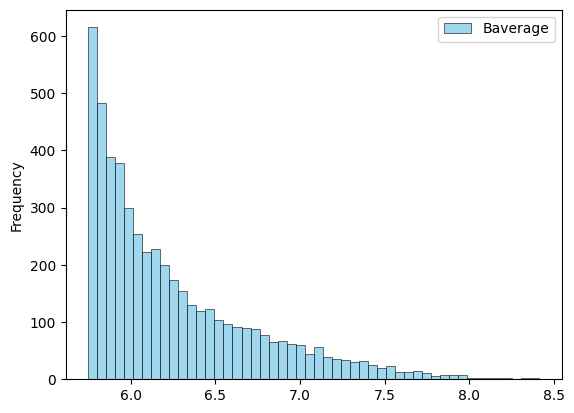

In [67]:
games_data_df.plot.hist(y='Baverage', bins=50, alpha=0.8, edgecolor='black', linewidth=0.5, color='skyblue')

<Axes: ylabel='Frequency'>

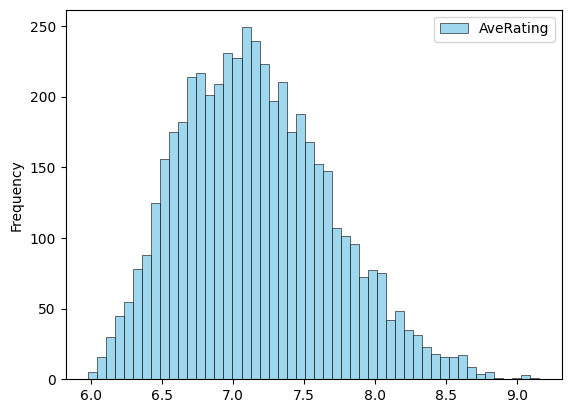

In [129]:
games_data_df.plot.hist(y='AveRating', bins=50, alpha=0.8, edgecolor='black', linewidth=0.5, color='skyblue')

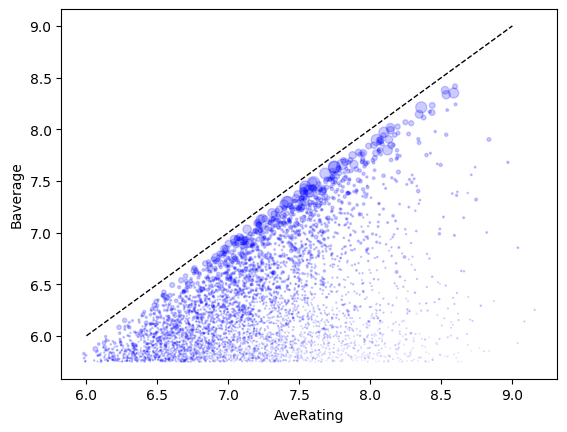

In [157]:
size = games_data_df['NumPlays'] / 10000
games_data_df.plot.scatter(x='AveRating', y='Baverage', s=size, alpha=0.2, color='blue')
plt.plot([6, 9], [6, 9], color='black', linewidth=1, linestyle='--')
plt.show()

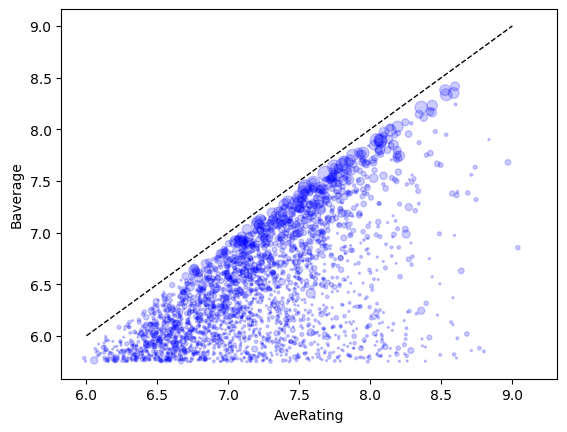

In [152]:
size = games_data_df['NumAwards'] * 2
games_data_df.plot.scatter(x='AveRating', y='Baverage', s=size, alpha=0.2, color='blue')
plt.plot([6, 9], [6, 9], color='black', linewidth=1, linestyle='--')
plt.show()

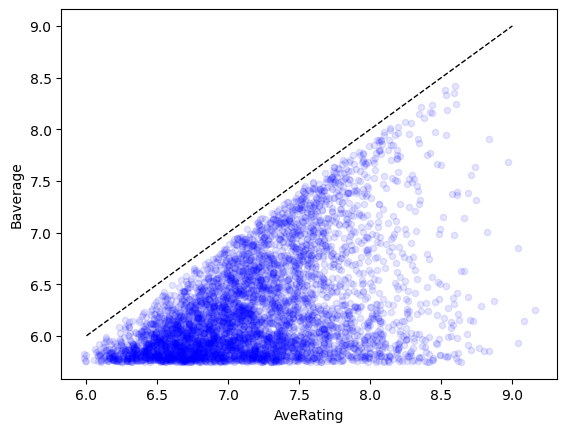

In [74]:
games_data_df.plot.scatter(x='AveRating', y='Baverage', alpha=0.1, color='blue')
# draw diagonal line
import matplotlib.pyplot as plt
plt.plot([6, 9], [6, 9], color='black', linewidth=1, linestyle='--')
plt.show()

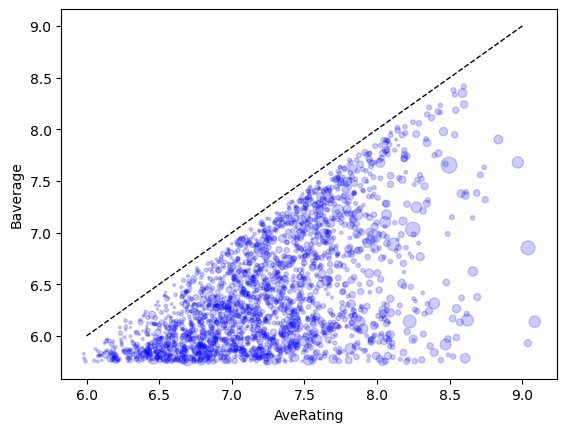

In [166]:
size = games_data_df['AmazonPrice'] / 5
games_data_df.plot.scatter(x='AveRating', y='Baverage', s=size, alpha=0.2, color='blue')
plt.plot([6, 9], [6, 9], color='black', linewidth=1, linestyle='--')
plt.show()

<Axes: xlabel='AveWeight', ylabel='Baverage'>

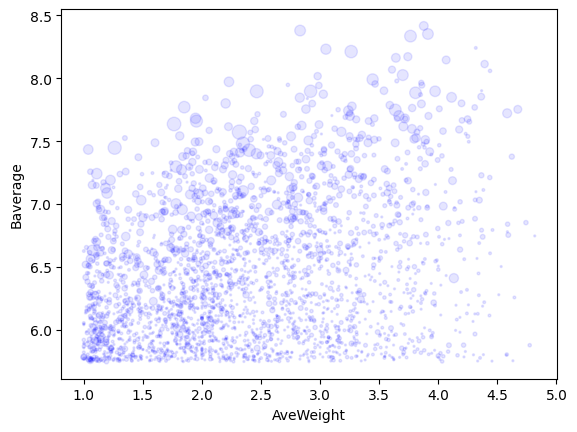

In [163]:
size = games_data_df['NumAwards'] * 2
games_data_df.plot.scatter(x='AveWeight', y='Baverage', s=size, alpha=0.1, color='blue')


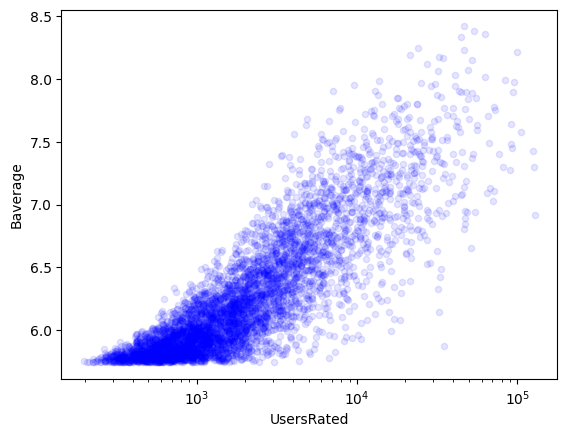

In [81]:
games_data_df.plot.scatter(x='UsersRated', y='Baverage', alpha=0.1, color='blue')
plt.xscale('log')

<Axes: xlabel='AmazonPrice', ylabel='Baverage'>

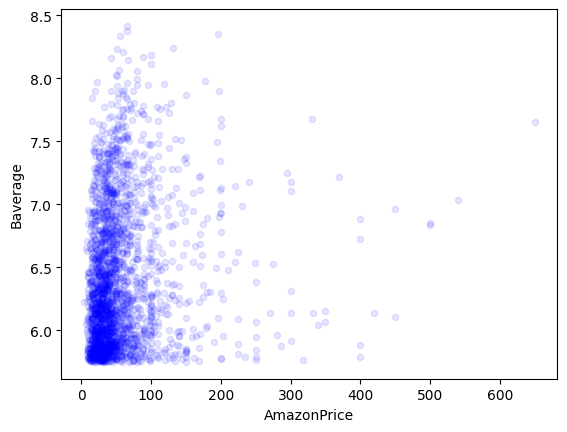

In [160]:
games_data_df.plot.scatter(x='AmazonPrice', y='Baverage', alpha=0.1, color='blue')

(0.0, 15.0)

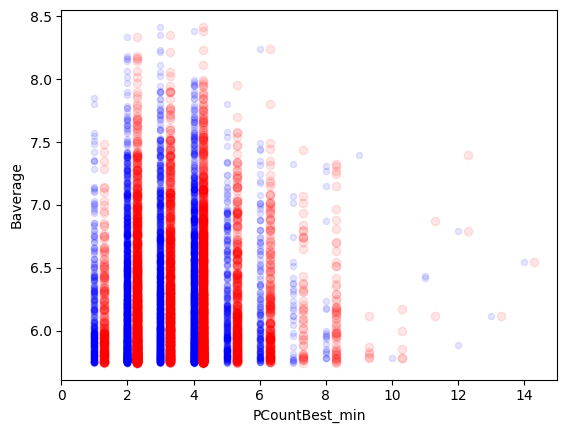

In [128]:
games_data_df.plot.scatter(x='PCountBest_min', y='Baverage', alpha=0.1, color='blue')
plt.scatter(games_data_df['PCountBest_max']+0.3, games_data_df['Baverage'], alpha=0.1, color='red')
plt.xlim(0, 15)

In [167]:
games_data_df.columns

Index(['Title', 'Link', 'Rank', 'Year', 'UsersRated', 'AveRating', 'Baverage',
       'StdDev', 'AveWeight', 'NumWeights', 'NumPlays', 'NumAwards',
       'PCountRecomm_min', 'PCountRecomm_max', 'PCountBest_min',
       'PCountBest_max', 'PCount_votes', 'MinPlayTime', 'MaxPlayTime',
       'Mechanics', 'GameCategory_1', 'RankCategory_1', 'ScoreCategory_1',
       'AmazonPrice', 'GameCategory_2', 'RankCategory_2', 'ScoreCategory_2',
       'GameCategory_3', 'RankCategory_3', 'ScoreCategory_3'],
      dtype='object')

In [171]:
(games_data_df
    .query('Rank < 1000')
    .query('Year > 2010')
    .query('PCountBest_min >= 2')
    .query('PCountBest_max <= 3')
).head(50)

,Title,Link,Rank,Year,UsersRated,AveRating,Baverage,StdDev,AveWeight,NumWeights,...,GameCategory_1,RankCategory_1,ScoreCategory_1,AmazonPrice,GameCategory_2,RankCategory_2,ScoreCategory_2,GameCategory_3,RankCategory_3,ScoreCategory_3
2,Gloomhaven,https://boardgamegeek.com/boardgame/174430/glo...,3,2017,62465,8.58674,8.35067,1.73879,3.9123,2576,...,Thematic,2.0,8.32928,196.32,Strategy,4.0,8.31230,NaN,NaN,NaN
3,Ark Nova,https://boardgamegeek.com/boardgame/342942/ark...,4,2021,44343,8.53430,8.33386,1.38510,3.7647,2337,...,Strategy,3.0,8.34315,55.00,NaN,NaN,NaN,NaN,NaN,NaN
6,Terraforming Mars,https://boardgamegeek.com/boardgame/167791/ter...,7,2016,99753,8.35802,8.21079,1.42112,3.2626,4131,...,Strategy,7.0,8.18815,59.97,NaN,NaN,NaN,NaN,NaN,NaN
7,War of the Ring: Second Edition,https://boardgamegeek.com/boardgame/115746/war...,8,2011,21547,8.54125,8.18547,1.47474,4.2161,1189,...,War,1.0,8.28477,99.90,Thematic,4.0,8.24477,NaN,NaN,NaN
8,Star Wars: Rebellion,https://boardgamegeek.com/boardgame/187645/sta...,9,2016,32686,8.41830,8.17041,1.36413,3.7424,1145,...,Thematic,5.0,8.20628,87.99,NaN,NaN,NaN,NaN,NaN,NaN
9,Gloomhaven: Jaws of the Lion,https://boardgamegeek.com/boardgame/291457/glo...,10,2020,34631,8.43441,8.16133,1.46771,3.6410,1000,...,Thematic,7.0,8.17130,42.97,Strategy,9.0,8.13864,NaN,NaN,NaN
10,Spirit Island,https://boardgamegeek.com/boardgame/162886/spi...,11,2017,52122,8.34379,8.14445,1.51100,4.0668,2859,...,Strategy,10.0,8.12426,66.20,NaN,NaN,NaN,NaN,NaN,NaN
13,Through the Ages: A New Story of Civilization,https://boardgamegeek.com/boardgame/182028/thr...,14,2015,31795,8.28743,8.05790,1.51805,4.4381,1575,...,Strategy,11.0,8.08904,79.95,NaN,NaN,NaN,NaN,NaN,NaN
14,Great Western Trail,https://boardgamegeek.com/boardgame/193738/gre...,15,2016,41016,8.19126,8.02445,1.31004,3.6992,1596,...,Strategy,15.0,8.04470,49.99,NaN,NaN,NaN,NaN,NaN,NaN
15,The Castles of Burgundy,https://boardgamegeek.com/boardgame/84876/the-...,16,2011,62604,8.14079,8.01591,1.24463,2.9789,2936,...,Strategy,16.0,8.01552,51.82,NaN,NaN,NaN,NaN,NaN,NaN


<Axes: xlabel='AveRating', ylabel='Baverage'>

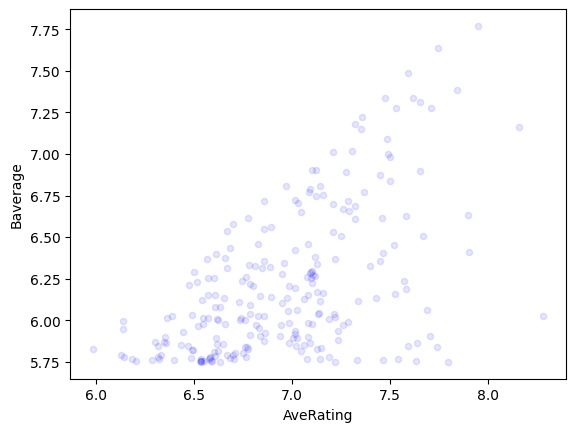

In [118]:
games_data_df.query('GameCategory_1 == "Abstract"').plot.scatter(x='AveRating', y='Baverage', alpha=0.1, color='blue')

# Predicting the Price in Amazon with the Features from BBG

In [132]:
(results.loc[:, ['Title', 'Rank', 'Year', 'UsersRated', 'AveRating', 'Baverage', 
                'AveWeight', 'NumWeights', 'NumPlays', 'NumAwards', 
                'PCountRecomm_min', 'PCountRecomm_max', 'PCountBest_min', 'PCountBest_max', 'PCount_votes',
                'MinPlayTime', 'MaxPlayTime', 'Category_1', 'AmazonPrice']]
    .head()
)

,Title,Rank,Year,UsersRated,AveRating,Baverage,AveWeight,NumWeights,NumPlays,NumAwards,PCountRecomm_min,PCountRecomm_max,PCountBest_min,PCountBest_max,PCount_votes,MinPlayTime,MaxPlayTime,Category_1,AmazonPrice
0,Brass: Birmingham,1,2018,46043,8.59731,8.41456,3.8789,2229,124812,20,2,4.0,3,4.0,1106,60,120,Strategy,$63.48
1,Pandemic Legacy: Season 1,2,2015,53558,8.52713,8.37875,2.8316,1461,287053,30,2,4.0,4,4.0,863,60,60,Thematic,$71.97
2,Gloomhaven,3,2017,62246,8.58836,8.35218,3.9115,2566,513581,30,1,4.0,3,3.0,1542,60,120,Thematic,$285.49
3,Ark Nova,4,2021,43695,8.53514,8.33503,3.7606,2297,342465,36,1,3.0,2,2.0,1762,90,150,Strategy,$56.92
4,Twilight Imperium: Fourth Edition,5,2017,23849,8.60087,8.24171,4.319,1166,41631,2,3,6.0,6,6.0,572,240,480,Thematic,$131.99


In [133]:
# remove space (' ') if its the last character in the string
results['Category_1'] = results['Category_1'].apply(lambda x: x[:-1] if (isinstance(x, str) and x.endswith(' ')) else x)
# change "'" inside the string to avoid SQL errors
results['Title'] = results['Title'].apply(lambda x: x.replace("'", "") if isinstance(x, str) else x)
results['Category_1'] = results['Category_1'].apply(lambda x: x.replace("'", "") if isinstance(x, str) else x)
# If Catergory_1 is NaN, set it to 'Uncategorized'
results['Category_1'] = results['Category_1'].apply(lambda x: 'Uncategorized' if x != x else x)
results['Category_1'] = results['Category_1'].apply(lambda x: 'Uncategorized' if x == None else x)
# Remove $ sign from AmazonPrice
results['AmazonPrice'] = results['AmazonPrice'].apply(lambda x: x.replace('$', '') if isinstance(x, str) else x)
# if not Unknown in AmazonPrice, convert to float
results['AmazonPrice'] = results['AmazonPrice'].apply(lambda x: float(x) if x != 'Unknown' else x)
# if not Unknown in Year, convert to int
results['Year'] = results['Year'].apply(lambda x: int(x) if x != 'Unknown' else x)
# These columns should contain integers: UsersRated, NumWeights, NumPlays, NumAwards, PCountRecomm_min, PCountRecomm_max, PCountBest_min, PCountBest_max, PCount_votes, MinPlayTime, MaxPlayTime
results['UsersRated'] = results['UsersRated'].apply(lambda x: int(x) if x != 'Unknown' else x)
results['NumWeights'] = results['NumWeights'].apply(lambda x: int(x) if x != 'Unknown' else x)
results['NumPlays'] = results['NumPlays'].apply(lambda x: int(x) if x != 'Unknown' else x)
results['NumAwards'] = results['NumAwards'].apply(lambda x: int(x) if x != 'Unknown' else x)
results['PCountRecomm_min'] = results['PCountRecomm_min'].apply(lambda x: int(x) if x != 'Unknown' else x)
results['PCountRecomm_max'] = results['PCountRecomm_max'].fillna(results['PCountRecomm_min'])
results['PCountRecomm_max'] = results['PCountRecomm_max'].apply(lambda x: int(x) if x != 'Unknown' else x)
# If PCountRecomm_max == nan then set it to PCountRecomm_min
results['PCountBest_min'] = results['PCountBest_min'].apply(lambda x: int(x) if x != 'Unknown' else x)
results['PCountBest_max'] = results['PCountBest_max'].fillna(results['PCountBest_min'])
results['PCountBest_max'] = results['PCountBest_max'].apply(lambda x: int(x) if x != 'Unknown' else x)
results['PCount_votes'] = results['PCount_votes'].apply(lambda x: int(x) if x != 'Unknown' else x)
results['MinPlayTime'] = results['MinPlayTime'].apply(lambda x: int(x) if x != 'NA' else x)
results['MaxPlayTime'] = results['MaxPlayTime'].apply(lambda x: int(x) if x != 'NA' else x)
# These columns should contain floats: AveRating, Baverage, StdDev, AveWeight
results['AveRating'] = results['AveRating'].apply(lambda x: float(x) if x != 'Unknown' else x)
results['Baverage'] = results['Baverage'].apply(lambda x: float(x) if x != 'Unknown' else x)
results['StdDev'] = results['StdDev'].apply(lambda x: float(x) if x != 'Unknown' else x)
results['AveWeight'] = results['AveWeight'].apply(lambda x: float(x) if x != 'Unknown' else x)

In [134]:
# These columns will not be used for the model
results.drop(['RankCat_1', 'ScoreCat_1', 'Category_2', 'RankCat_2', 'ScoreCat_2', 'Category_3', 'RankCat_3', 'ScoreCat_3'], axis=1, inplace=True)

In [135]:
(results[results.isnull().any(axis=1)]
#    .Link
    .T
 )

""
Title
Link
Rank
Year
UsersRated
AveRating
Baverage
StdDev
AveWeight
NumWeights


In [136]:
results['Category_1'] = results['Category_1'].astype('category')

In [137]:
results.dtypes

Title                 object
Link                  object
Rank                   int64
Year                   int64
UsersRated             int64
AveRating            float64
Baverage             float64
StdDev               float64
AveWeight            float64
NumWeights             int64
NumPlays               int64
NumAwards              int64
PCountRecomm_min       int64
PCountRecomm_max       int64
PCountBest_min         int64
PCountBest_max         int64
PCount_votes           int64
MinPlayTime            int64
MaxPlayTime            int64
Mechanics             object
Category_1          category
AmazonPrice           object
dtype: object

In [138]:
(results
    .query('AmazonPrice != "Unknown"')
)

,Title,Link,Rank,Year,UsersRated,AveRating,Baverage,StdDev,AveWeight,NumWeights,...,PCountRecomm_min,PCountRecomm_max,PCountBest_min,PCountBest_max,PCount_votes,MinPlayTime,MaxPlayTime,Mechanics,Category_1,AmazonPrice
0,Brass: Birmingham,https://boardgamegeek.com/boardgame/224517/bra...,1,2018,46043,8.59731,8.41456,1.41606,3.8789,2229,...,2,4,3,4,1106,60,120,Hand Management\nIncome\nLoans\nMarket\nNetwor...,Strategy,63.48
1,Pandemic Legacy: Season 1,https://boardgamegeek.com/boardgame/161936/pan...,2,2015,53558,8.52713,8.37875,1.59840,2.8316,1461,...,2,4,4,4,863,60,60,Action Points\nCooperative Game\nHand Manageme...,Thematic,71.97
2,Gloomhaven,https://boardgamegeek.com/boardgame/174430/glo...,3,2017,62246,8.58836,8.35218,1.73928,3.9115,2566,...,1,4,3,3,1542,60,120,Action Queue\nAction Retrieval\nCampaign / Bat...,Thematic,285.49
3,Ark Nova,https://boardgamegeek.com/boardgame/342942/ark...,4,2021,43695,8.53514,8.33503,1.38399,3.7606,2297,...,1,3,2,2,1762,90,150,Action Queue\nEnd Game Bonuses\nGrid Coverage\...,Strategy,56.92
4,Twilight Imperium: Fourth Edition,https://boardgamegeek.com/boardgame/233078/twi...,5,2017,23849,8.60087,8.24171,1.62048,4.3190,1166,...,3,6,6,6,572,240,480,Action Drafting\nArea-Impulse\nDice Rolling\nF...,Thematic,131.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3301,Sequence,https://boardgamegeek.com/boardgame/2375/sequence,3302,1982,10556,6.12146,5.93070,1.49566,1.3147,502,...,2,4,3,4,107,10,30,Hand Management\nPattern Building\nTake That\n...,Family,14.97
3305,Valparaíso,https://boardgamegeek.com/boardgame/257058/val...,3306,2018,952,6.87959,5.92737,1.12636,2.8049,41,...,2,5,5,5,25,45,90,Action Queue\nKill Steal\nPoint to Point Movem...,Strategy,48.95
3307,Dungeons & Dragons: Rock Paper Wizard,https://boardgamegeek.com/boardgame/207062/dun...,3308,2016,1530,6.57288,5.93244,1.36025,1.3333,27,...,3,6,5,6,17,30,30,Simultaneous Action Selection\nTake That\n,Party,21.72
3310,The Blood of an Englishman,https://boardgamegeek.com/boardgame/206504/blo...,3311,2016,1496,6.54979,5.92681,1.23373,1.8261,23,...,2,2,2,2,10,20,30,Pattern Building\nVariable Player Powers\n,Family,16.19


In [155]:
data = (
    results
        .loc[:, ['Rank', 'Year', 'UsersRated', 'AveRating', 'Baverage', 
                'AveWeight', 'NumWeights', 'NumPlays', 'NumAwards', 
                'PCountRecomm_min', 'PCountRecomm_max', 'PCountBest_min', 'PCountBest_max', 'PCount_votes',
                'MinPlayTime', 'MaxPlayTime', 'Category_1', 'AmazonPrice']]
        .query('AmazonPrice != "Unknown"')
        .query('AmazonPrice < 200')
        .copy()
)

In [156]:
data.AmazonPrice.describe()

count     1695.00
unique     982.00
top         39.99
freq        31.00
Name: AmazonPrice, dtype: float64

In [160]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

features = data.columns[1:-1]

X = data[features]
y = data['AmazonPrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

model = XGBRegressor(objective='reg:squarederror', 
                     enable_categorical=True,
                     verbosity=0,
                     n_estimators=1000,
                     max_depth=10,
                     learning_rate=0.1,
                     subsample=0.9,
                     colsample_bytree=0.9,
                     reg_lambda=1,
                     reg_alpha=0,
                     gamma=0,
                     min_child_weight=1,)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

In [163]:
print(f'Mean Squared Error: {mse:.2f}')
print(f'Mean Absolute Error: {mae:.2f}')
print(f'R^2: {model.score(X_test, y_test):.2f}')

Mean Squared Error: 937.38
Mean Absolute Error: 20.68
R^2: 0.30


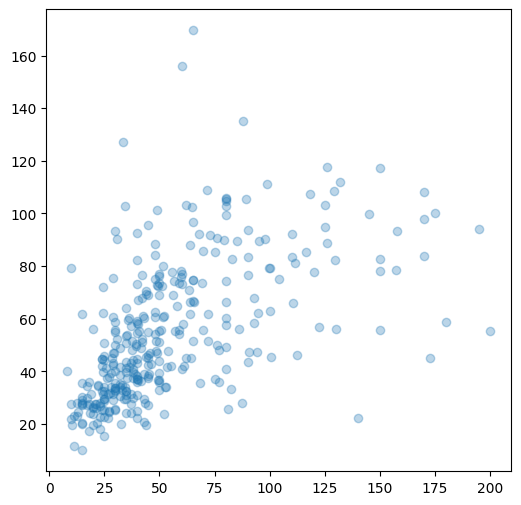

In [165]:
# plot true vs predicted values
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.3)